# 성능 최적화 종합실습 : Car seat sales
유아용 카시트 매출액을 예측해 봅시다.

* 카시트에 대해서 지역 매장 별 매출액을 예측하고자 합니다.

![](https://cdn.images.express.co.uk/img/dynamic/24/590x/child-car-seat-986556.jpg?r=1532946857754)

## 1.환경준비

### (1) Import

In [1]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 모델링
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import * 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings(action='ignore')

### (2) 함수 생성

* 선형회귀용 전진선택법

In [2]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

def forward_stepwise_linear(x_train, y_train):

    # 변수목록, 선택된 변수 목록, 단계별 모델과 AIC 저장소 정의
    features = list(x_train)
    selected = []
    step_df = pd.DataFrame({ 'step':[], 'feature':[],'aic':[]})

    # 
    for s in range(0, len(features)) :
        result =  { 'step':[], 'feature':[],'aic':[]}

        # 변수 목록에서 변수 한개씩 뽑아서 모델에 추가
        for f in features :
            vars = selected + [f]
            x_tr = x_train[vars]
            model = OLS(y_train, add_constant(x_tr)).fit()
            result['step'].append(s+1)
            result['feature'].append(vars)
            result['aic'].append(model.aic)
        
        # 모델별 aic 집계
        temp = pd.DataFrame(result).sort_values('aic').reset_index(drop = True)

        # 만약 이전 aic보다 새로운 aic 가 크다면 멈추기
        if step_df['aic'].min() < temp['aic'].min() :
            break
        step_df = pd.concat([step_df, temp], axis = 0).reset_index(drop = True)

        # 선택된 변수 제거
        v = temp.loc[0,'feature'][s]
        features.remove(v)

        selected.append(v)
    
    # 선택된 변수와 step_df 결과 반환
    return selected, step_df

* 변수 중요도 그래프

In [3]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

### (3) Data Loading

In [9]:
data_path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/Carseats.csv'
data = pd.read_csv(data_path)

**변수설명**
* Sales - 각 지역 판매량(단위 : 1000개) <== Target
* CompPrice - 각 지역 경쟁사 가격
* Income - 각 지역 평균 소득수준(단위 : 1000달러)
* Advertising - 각 지역, 회사의 광고 예산(단위 : 1000달러)
* Population - 지역 인구수(단위 : 1000명)
* Price - 자사 지역별 판매가격
* ShelveLoc - 진열상태
* Age - 지역 인구의 평균 연령
* Education - 각 지역 교육수준 레벨
* Urban - 매장 도시 지역 여부
* US - 매장이 미국에 있는지 여부

## 2.데이터 이해

* 둘러보기

In [10]:
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


## 3.데이터 준비

### (1) 데이터 정리

In [11]:
data['Diff_Price'] = data['CompPrice'] - data['Price']
data.drop(['Education', 'CompPrice'], axis = 1, inplace = True)

### (2) 데이터분할1 : x, y 나누기

In [12]:
x = data.drop('Sales', axis=1)
y = data.loc[:, 'Sales']

### (3) NA 조치

### (4) 가변수화

In [13]:
cols = ['ShelveLoc', 'Urban', 'US']
x = pd.get_dummies(x, columns=cols, drop_first=True)

### (5) 데이터분할2 : train : validation 나누기

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3)

### (6) Scaling
KNN 알고리즘을 적용하기 위해서는 스케일링을 해야 합니다.

In [15]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

## 4.모델링



### (1) 선형회귀

In [85]:
vars, result = forward_stepwise_linear(x_train, y_train)

In [106]:
vars

['Diff_Price',
 'ShelveLoc_Good',
 'Advertising',
 'Age',
 'ShelveLoc_Medium',
 'Income']

In [87]:
m = LinearRegression()
m.fit(x_train[vars], y_train)

LinearRegression()

In [97]:
pred1 = m.predict(x_val[vars])

In [98]:
print(f'RMSE: {mean_squared_error(y_val, pred1, squared=False)}')
print(f'MAE: {mean_absolute_error(y_val, pred1)}')
print(f'MAPE: {mean_absolute_percentage_error(y_val, pred1)}')

RMSE: 1.06167606910203
MAE: 0.8445446764142666
MAPE: 0.18404336139870045


### (2) KNN

In [19]:
params = {'n_neighbors': range(1, 21), 'metric' : ['euclidean', 'manhattan']}

In [20]:
knn_gs = GridSearchCV(KNeighborsRegressor(), params, cv=5)

In [21]:
knn_gs.fit(x_train_s, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 21)})

In [22]:
knn_gs.best_params_

{'metric': 'manhattan', 'n_neighbors': 7}

In [23]:
result = pd.DataFrame(knn_gs.cv_results_)
tmp = result.loc[:, ['param_n_neighbors', 'param_metric', 'mean_test_score']]
tmp.head()

,param_n_neighbors,param_metric,mean_test_score
0,1,euclidean,0.378045
1,2,euclidean,0.494684
2,3,euclidean,0.486048
3,4,euclidean,0.529674
4,5,euclidean,0.506923


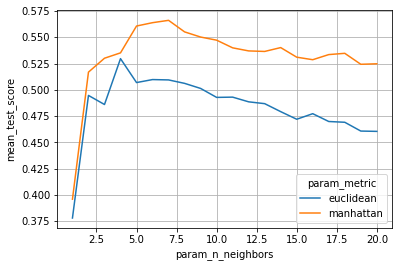

In [26]:
plt.figure(figsize=(6, 4))
sns.lineplot('param_n_neighbors', 'mean_test_score', data = tmp , hue = 'param_metric')
plt.grid()
plt.show()

In [99]:
pred2 = knn_gs.predict(x_val_s)

print(f'RMSE: {mean_squared_error(y_val, pred2, squared=False)}')
print(f'MAE: {mean_absolute_error(y_val, pred2)}')
print(f'MAPE: {mean_absolute_percentage_error(y_val, pred2)}')

RMSE: 1.77224515548963
MAE: 1.4398095238095239
MAPE: 0.4000956903246954


### (3) Decision Tree

In [36]:
params = {'max_depth': range(1, 11), 'min_samples_leaf': range(15, 61, 15)}

In [37]:
dt_gs = GridSearchCV(DecisionTreeRegressor(), params, cv=5)

In [38]:
dt_gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 11),
                         'min_samples_leaf': range(15, 61, 15)})

In [39]:
dt_gs.best_params_

{'max_depth': 7, 'min_samples_leaf': 15}

In [40]:
result = pd.DataFrame(dt_gs.cv_results_)
tmp = result.loc[:, ['param_max_depth', 'param_min_samples_leaf', 'mean_test_score']]
tmp.head()

,param_max_depth,param_min_samples_leaf,mean_test_score
0,1,15,0.208412
1,1,30,0.208412
2,1,45,0.208412
3,1,60,0.234478
4,2,15,0.508738


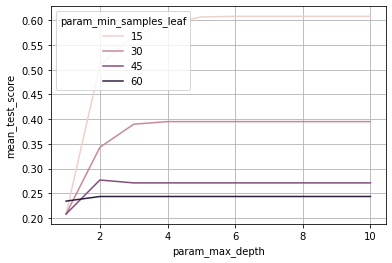

In [41]:
plt.figure(figsize=(6, 4))
sns.lineplot('param_max_depth', 'mean_test_score', data = tmp , hue = 'param_min_samples_leaf')
plt.grid()
plt.show()

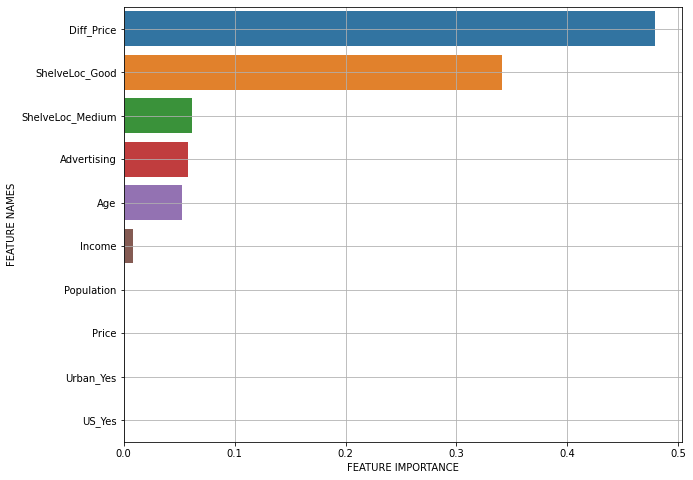

In [94]:
r = plot_feature_importance(dt_gs.best_estimator_.feature_importances_, list(x_train))

In [100]:
pred3 = dt_gs.predict(x_val)

print(f'RMSE: {mean_squared_error(y_val, pred3, squared=False)}')
print(f'MAE: {mean_absolute_error(y_val, pred3)}')
print(f'MAPE: {mean_absolute_percentage_error(y_val, pred3)}')

RMSE: 1.7195720267440704
MAE: 1.3820014086706645
MAPE: 0.35904393173235577


### (4) Random Forest

In [43]:
params = {'n_estimators': range(30, 160, 30), 'max_features': range(1, 21)}

In [44]:
rf_gs = GridSearchCV(RandomForestRegressor(), params, cv=5)

In [45]:
rf_gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': range(1, 21),
                         'n_estimators': range(30, 160, 30)})

In [47]:
rf_gs.best_params_

{'max_features': 6, 'n_estimators': 60}

In [48]:
result = pd.DataFrame(rf_gs.cv_results_)
tmp = result.loc[:, ['param_n_estimators', 'param_max_features', 'mean_test_score']]
tmp.head()

,param_n_estimators,param_max_features,mean_test_score
0,30,1,0.594953
1,60,1,0.614616
2,90,1,0.622377
3,120,1,0.630834
4,150,1,0.637462


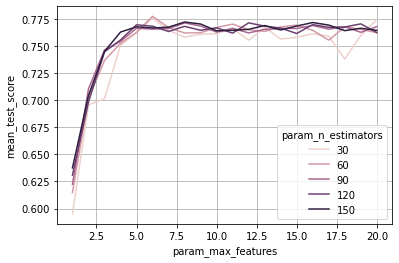

In [49]:
plt.figure(figsize=(6, 4))
sns.lineplot('param_max_features', 'mean_test_score', data = tmp , hue = 'param_n_estimators')
plt.grid()
plt.show()

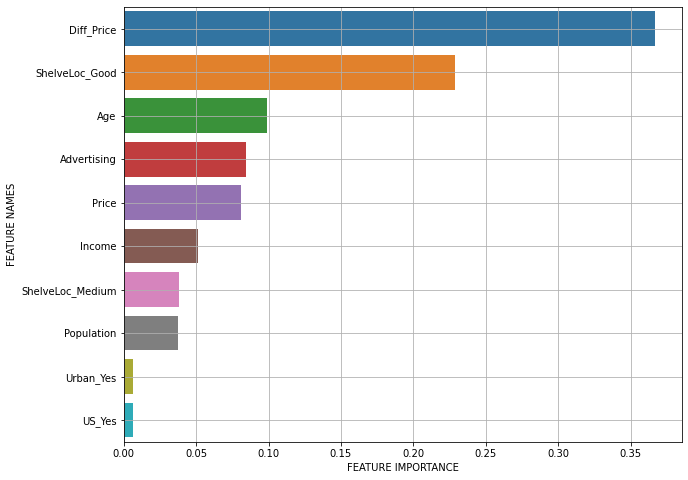

In [95]:
r = plot_feature_importance(rf_gs.best_estimator_.feature_importances_, list(x_train))

In [101]:
pred4 = rf_gs.predict(x_val)

print(f'RMSE: {mean_squared_error(y_val, pred4, squared=False)}')
print(f'MAE: {mean_absolute_error(y_val, pred4)}')
print(f'MAPE: {mean_absolute_percentage_error(y_val, pred4)}')

RMSE: 1.4027385760473978
MAE: 1.1081125
MAPE: 0.3424296813402894


### (5) SVM

In [117]:
params = {'C': range(10, 101, 10), 'gamma': [.001, .01, .1, 1]}

In [118]:
svm_gs = GridSearchCV(SVR(), params, cv=5)

In [119]:
svm_gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': range(10, 101, 10),
                         'gamma': [0.001, 0.01, 0.1, 1]})

In [120]:
svm_gs.best_params_

{'C': 40, 'gamma': 0.001}

In [121]:
result = pd.DataFrame(svm_gs.cv_results_)
tmp = result.loc[:, ['param_C', 'param_gamma', 'mean_test_score']]
tmp.head()

,param_C,param_gamma,mean_test_score
0,10,0.001,0.101434
1,10,0.01,-0.004427
2,10,0.1,-0.010234
3,10,1,-0.010225
4,20,0.001,0.103375


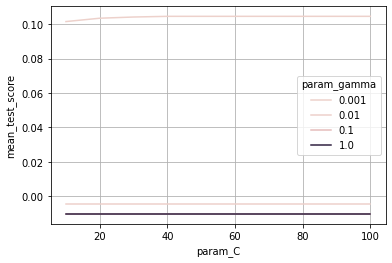

In [122]:
plt.figure(figsize=(6, 4))
sns.lineplot('param_C', 'mean_test_score', data = tmp , hue = 'param_gamma')
plt.grid()
plt.show()

In [123]:
pred5 = svm_gs.predict(x_val)

print(f'RMSE: {mean_squared_error(y_val, pred5, squared=False)}')
print(f'MAE: {mean_absolute_error(y_val, pred5)}')
print(f'MAPE: {mean_absolute_percentage_error(y_val, pred5)}')

RMSE: 2.588645302089278
MAE: 2.039378996507606
MAPE: 0.6026657317714951


### (6) XGB

In [107]:
params = {'learning_rate':np.linspace(0.01,0.2,20), 'n_estimators':[20,30,50,100]}

In [108]:
xgb_gs = GridSearchCV(XGBRegressor(objective='reg:squarederror'), params, cv=5)

In [109]:
xgb_gs.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
                         'n_estimators': [20, 30, 50, 100]})

In [110]:
xgb_gs.best_params_

{'learning_rate': 0.13, 'n_estimators': 50}

In [111]:
result = pd.DataFrame(xgb_gs.cv_results_)
tmp = result.loc[:, ['param_n_estimators', 'param_learning_rate', 'mean_test_score']]
tmp.head()

,param_n_estimators,param_learning_rate,mean_test_score
0,20,0.01,-3.952535
1,30,0.01,-3.146219
2,50,0.01,-1.942345
3,100,0.01,-0.340428
4,20,0.02,-2.473277


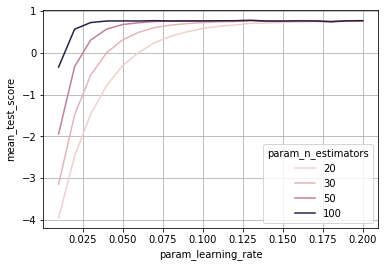

In [112]:
plt.figure(figsize=(6, 4))
sns.lineplot('param_learning_rate', 'mean_test_score', data = tmp , hue = 'param_n_estimators')
plt.grid()
plt.show()

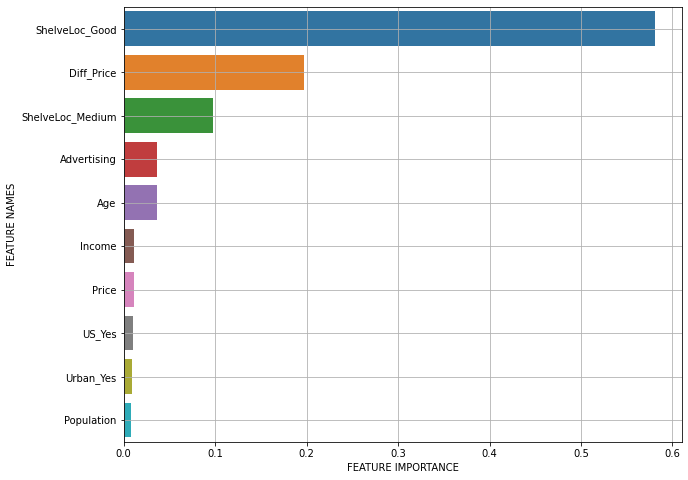

In [113]:
r = plot_feature_importance(xgb_gs.best_estimator_.feature_importances_, list(x_train))

In [114]:
pred6 = rf_gs.predict(x_val)

print(f'RMSE: {mean_squared_error(y_val, pred6, squared=False)}')
print(f'MAE: {mean_absolute_error(y_val, pred6)}')
print(f'MAPE: {mean_absolute_percentage_error(y_val, pred6)}')

RMSE: 1.4027385760473978
MAE: 1.1081125
MAPE: 0.3424296813402894


In [124]:
models = ['LR', 'KNN', 'DT', 'RF', 'SVM', 'XGB']
preds = [pred1, pred2, pred3, pred4, pred5, pred6]
rmse, mae, mape = [], [], []

for pred in preds:
    rmse.append(mean_squared_error(y_val, pred, squared=False))
    mae.append(mean_absolute_error(y_val, pred))
    mape.append(mean_absolute_percentage_error(y_val, pred))

result = pd.DataFrame({'Model': models, 'RMSE': rmse, 'MAE':mae, 'MAPE':mape})

In [125]:
result

,Model,RMSE,MAE,MAPE
0,LR,1.061676,0.844545,0.184043
1,KNN,1.772245,1.439810,0.400096
2,DT,1.719572,1.382001,0.359044
3,RF,1.402739,1.108113,0.342430
4,SVM,2.588645,2.039379,0.602666
5,XGB,1.402739,1.108113,0.342430
